In [25]:
%matplotlib inline
import pandas as pd

In [26]:
# 메타 데이터와 학습용 평점 정보 불러오기
metadata = pd.read_csv('metadata.csv')
ratings = pd.read_csv('ratings-train.csv')

In [27]:
# validation용 평점 정보 불러오기
# 데이터가 너무 크기 때문에 20%(frac = 0.2) 크기만 샘플링
# 학습하는 모두가 같은 샘플 데이터를 갖도록 random_state를 같은 값(17)으로 고정
ratings_valid = pd.read_csv('ratings-valid.csv').sample(random_state=17, frac=0.2)

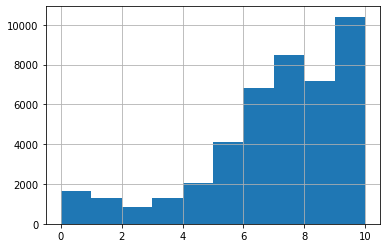

In [28]:
# 평점 정보의 분포 그려보기 (p. 20)
ratings['rating'].hist()

In [29]:
expected = ratings_valid[1:10]
answer = ratings_valid[:10]

In [30]:
# RMSE 계산하는 함수 만들기 (p. 23)
import numpy as np
def rmse(expected, answer):
    joined = pd.merge(answer, expected, on=['userid', 'itemid'], how='left')
    joined['rating_y'] = joined['rating_y'].fillna(0)
    joined['square_error'] = (joined['rating_x'] - joined['rating_y']) ** 2
    return np.sqrt(joined['square_error'].mean())

In [6]:
rmse(expected, answer)

2.8460498941515415

In [7]:
# 모든 예측을 8점으로 하는 추천 로직
def predict(u, i):
    return 8.0

expected = ratings_valid.copy() #valid set 복사 (원본 데이터 훼손 안하려고)
expected['rating'] = expected.apply( 
    lambda row: predict(row['userid'], row['itemid']), axis=1) 
#예측한 데이터를 넣어주기 
# .apply 함수로 lambda 써서 expected에 rating 칼럼을 만들어서 예측 데이터를 넣어줌 

rmse(expected, ratings_valid)

2.7423239390279464

In [8]:
# 모든 예측을 전체 평점의 평균으로 계산하는 추천 로직 (p. 24)
r_mean = ratings['rating'].mean()
def predict(u, i):
    return r_mean

expected = ratings_valid.copy()
expected['rating'] = expected.apply(
    lambda row: predict(row['userid'], row['itemid']), axis=1)

rmse(expected, ratings_valid)

2.418031954051125

In [9]:
# 모든 예측을 주어진 사용자의 평균 평점으로 계산하는 추천 로직 (p. 25)
def predict(u, i):
    return ratings[ratings['userid'] == u]['rating'].mean()

expected = ratings_valid.copy()
expected['rating'] = expected.apply(
    lambda row: predict(row['userid'], row['itemid']), axis=1)

rmse(expected, ratings_valid)

2.1909154513519242

In [10]:
# 모든 예측을 주어진 영화의 평균 평점으로 계산하는 추천 로직 (p. 25)
def predict(u, i):
    return ratings[ratings['itemid'] == i]['rating'].mean()

expected = ratings_valid.copy()
expected['rating'] = expected.apply(
    lambda row: predict(row['userid'], row['itemid']), axis=1)

rmse(expected, ratings_valid)

2.237838086446809

In [38]:
# 서로 다른 사용자 u, v에 대해 jaccard similarity 계산하는 함수 (p. 28)
all_users = ratings['userid'].unique()
i_dict = {u: set(ratings[ratings['userid'] == u]['itemid']) for u in all_users}
def sim(u, v):
    # i_u = set(ratings[ratings['userid'] == u]['itemid'])
    # i_v = set(ratings[ratings['userid'] == v]['itemid'])
    i_u = i_dict[u]
    i_v = i_dict[v]
    
    cup = i_u | i_v
    if len(cup) == 0:
        return 0.0
    cap = i_u & i_v
    return len(cap) / len(cup)

In [39]:
sim('TERhUA==', 'Q1ladXM=')

0.08333333333333333

In [82]:
# 비슷한 영화를 소비한 k명의 사용자 집합 U_u를 계산하는 similar_users(u, k) 함수 (p. 29)
def similar_users(u, k):
    sims = sorted([(sim(u, v), v) for v in all_users if u != v], reverse=True)
    topk_users = [v for s, v in sims][:k]
    return pd.DataFrame(topk_users, columns=['userid'])

In [54]:
# 위에 내용 잘라서 코드 넣기 
def similar_users(u, k):
    # (자카드 sim 계산, 어떤 유저인지)  u 중 u는 중복이니까 빼야함 그래서 u != v랑 다음 
    sims = [(sim(u, v), v) for v in all_users if u != v]
    # 어떤 유저인지 유사도 정렬, 내림차순
    sorted_sims = sorted(sims,  reverse=True)
    topk_sims = sorted_sims[:k] # 상위 k개만 뽑기 (앞에서부터 가장 큰 sim 유저가 나옴)
    topk_users = [v for s, v in topk_sims] # user만 따로 빼기 (s-u랑 짝인데 유저만 가지고)
    return pd.DataFrame(topk_users, columns=['userid'])

In [55]:
similar_users('TERhUA==', 5)

,userid
0,YzkyQQ==
1,NGdmcVQ=
2,M2hETGQ=
3,V0NyaQ==
4,QTB5d0E=


In [80]:
def predict(u, i):
    topk_users = similar_users(u, 5)
    topk_users['sim'] = topk_users.apply(lambda row: sim(u, row['userid']), axis=1)
    i_ratings = ratings[ratings['itemid'] == i]
    joined = pd.merge(topk_users, i_ratings, on='userid')
    joined['weighted_rating'] = joined['sim'] * joined['rating']
    return joined['weighted_rating'].sum() / joined['sim'].sum()

In [16]:
expected = ratings_valid.copy()
expected['rating'] = expected.apply(
    lambda row: predict(row['userid'], row['itemid']), axis=1)

rmse(expected, ratings_valid)
# rmse가 4.4까지 떨어짐 (더 안 좋은 로직)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


4.4360709881776135

In [66]:
#5 
# top_k 유저를 i 영화를 본 적이 있는 사람 중에 고른다. 
# sum{(u와 v의 sim)(v의 i평점 - v의 전체 평점 평균)}
# 유저별 평균 평균 평점 구하기 
def predict_mean(u,i):
    return ratings[ratings['userid'] == u]['rating'].mean()

def similar_users(u, k, a):
    sims = sorted([(sim(u, v), v) for v in a if u != v], reverse=True)
    topk_users = [v for s, v in sims][:k]
    return pd.DataFrame(topk_users, columns=['userid'])

def preditc(u,i):
    a = ratings[ratings['itemid']==i]['userid'].unique()
    topk_users = similar_users(u,5,a)
    topk_users['sim'] = topk_users.apply(lambda row:sim(u,row['userid']),axis=1)
    topk_users['mean'] = topk_users.apply(lambda reow:predict_mean(row['userid'],0), axis=1)
    i_ratings = ratings[ratings['itemid']==i]
    joined = pd.merge(topk_users, i_ratings, on ='userid')
    joined['weighted_rating'] = joined['sim']*(joined['rating']-joined['mean'])
    sum_j = joined['weighted_rating'].sum()/joined['sim'].sum()
    r_u_mean = predict_mean(u,2)
    return r_u_mean + sum_j

In [67]:

expected = ratings_valid.copy()
expected['rating'] = expected.apply(
    lambda row: predict(row['userid'], row['itemid']), axis=1)

rmse(expected, ratings_valid)

TypeError: ("similar_users() missing 1 required positional argument: 'a'", 'occurred at index 1000')

In [70]:
#    top_k 유저를 i 영화를 본 적이 있는 사람 중에 고른다.
#    sum{(u와 v의 sim)(v의 i평점 - v의 전체 평점 평균)}
#         ----------  -------      ---------------
#    ----      1        2               3
#      4
#    u의 전체 영화 평균 => 5

# 비슷한 영화를 소비한 k명의 사용자 집합 U_u를 계산하는 similar_users(u, k) 함수 (p. 29)

# 모든 예측을 주어진 사용자의 평균 평점으로 계산하는 추천 로직

def predict_umean(u, i):
    return ratings[ratings['userid'] == u]['rating'].mean()

def similar_users(u, k, a):
    sims = sorted([(sim(u, v), v) for v in a if u != v], reverse=True)
    topk_users = [v for s, v in sims][:k]
    return pd.DataFrame(topk_users, columns=['userid'])

def predict(u, i):  
    a = ratings[ratings['itemid'] == i]['userid'].unique()
    topk_users = similar_users(u, 5, a)
        # 1 (u와 v의 sim)
    topk_users['sim'] = topk_users.apply(lambda row: sim(u, row['userid']), axis=1)
    
    # 3 (v의 전체 평점 평균)
    
    topk_users['mean_rate'] = topk_users.apply(lambda row: predict_umean(row['userid'], 0), axis=1)
    
    # 2 (i영화의 유저마다 평점)
    i_ratings = ratings[ratings['itemid'] == i]
    
    joined = pd.merge(topk_users, i_ratings, on='userid')
    
    joined['weighted_rating'] = joined['sim'] * (joined['rating'] - joined['mean_rate'])
   
    # 4 
    sum_j = joined['weighted_rating'].sum() / joined['sim'].sum()
    
    # 5
    r_u_mean = predict_umean(u, 2)
    
    return r_u_mean + sum_j

In [71]:

expected = ratings_valid.copy()
expected['rating'] = expected.apply(
    lambda row: predict(row['userid'], row['itemid']), axis=1)

rmse(expected, ratings_valid)

2.131802386637612

In [ ]:
# u의 평균평점 + 1/sum(sim(u, v)) * sum(sim(u,v)*(i에 대한 v의 평점 - v의 평균 평점))

def predict_bonus(u, i):
    # u 유저의 평균
    r_bar = predict_u_mean(u)
    
    # top k명 유저 찾기
    topk_users = similar_users(u, 5)
    # sim 컬럼에 top k 유저들과 u의 similarity 값 저장
    topk_users['sim'] = topk_users.apply(lambda row: sim(u, row['userid']), axis=1)
    # top k 유저들이 본 모든 영화의 rating 가져오기
    topk_users_with_rating = topk_users.merge(ratings_valid, how='left', on='userid')
    # mean 컬럼에 top k 유저들의 평균 평점 저장
    topk_users_with_rating['mean'] = topk_users_with_rating.apply(lambda row: predict_u_mean(row['userid']), axis=1)
    # top k 유저들이 본 영화들 중 영화 i의 값만 가져옴
    topk_users_with_i_rating = topk_users_with_rating[topk_users_with_rating['itemid'] == i]
    
    # 가중평균 계산해서 weighted 컬럼에 저장
    topk_users_with_i_rating['weighted'] = topk_users_with_i_rating['sim']*(topk_users_with_i_rating['rating']-topk_users_with_i_rating['mean'])
    
    # 분모가 0일 경우 u 유저의 평균만 반환
    return r_bar if topk_users_with_i_rating['sim'].sum() == 0 else r_bar + topk_users_with_i_rating['weighted'].sum() / topk_users_with_i_rating['sim'].sum()

In [109]:
# 선생님 코드 
r_mean = ratings.groupby('userid')['rating'].mean().reset_index()
def predict(u,i):
    topk = similar_users(u,5) #k 값을 10으로 늘리면 2.19로 더 괜찮아짐 
    topk['sim'] = topk.apply(lambda x: sim(u,x['userid']), axis=1)
    joined =pd.merge(topk, ratings[ratings['itemid']==i], on = 'userid')
    joined = pd.merge(joined, r_mean, on='userid')
    joined['score'] = joined['sim']*(joined['rating_x']-joined['rating_y'])
    # x 값이 항사 클까? 노노 만약 더 작다면 유저가 평균보다 더 낮은 값을 준 영화 -> 아! 싫어하구나 라고 판단할 수 있음 
    mean_u =r_mean[r_mean['userid']==u]['rating'].iloc[0]
    sim_sum = joined['sim'].sum()
    r_ui = mean_u
    if sim_sum != 0.0:
        r_ui += joined['score'].sum()/sim_sum  #심섬이 0일 때, 유저의 평균을 반환한다
        
    return r_ui

expected = ratings_valid.copy()
expected['rating'] = expected.apply(lambda row: predict(row['userid'], row['itemid']), axis=1)

rmse(expected, ratings_valid)

2.24504610396613

### 하나씩 따로 봐보자 

In [93]:
u = 'TERhUA=='
i = 96644
topk = similar_users(u,5)
topk

,userid
0,YzkyQQ==
1,NGdmcVQ=
2,M2hETGQ=
3,V0NyaQ==
4,QTB5d0E=


In [94]:
topk['sim'] = topk.apply(lambda x: sim(u,x['userid']), axis=1)

In [96]:
# i 아이템만 뽑아와야 함 
joined =pd.merge(topk, ratings[ratings['itemid']==i], on = 'userid')
joined

,userid,sim,itemid,rating
0,YzkyQQ==,0.142857,96644,10
1,NGdmcVQ=,0.125000,96644,10


In [98]:
joined = pd.merge(joined, r_mean, on='userid')
joined

,userid,sim,itemid,rating_x,rating_y,rating
0,YzkyQQ==,0.142857,96644,10,7.5,7.5
1,NGdmcVQ=,0.125000,96644,10,9.0,9.0


In [102]:
# 수식의 시그마 안에 들어있는 것을 score라고 호칭해줌 
joined['score'] = joined['sim']*(joined['rating_x']-joined['rating_y'])
joined

,userid,sim,itemid,rating_x,rating_y,rating,score
0,YzkyQQ==,0.142857,96644,10,7.5,7.5,0.357143
1,NGdmcVQ=,0.125000,96644,10,9.0,9.0,0.125000


In [104]:
r_mean[r_mean['userid']==u]['rating'].iloc[0]

9.375

In [105]:
mean_u =r_mean[r_mean['userid']==u]['rating'].iloc[0]
r_ui =joined['score'].sum()/joined['sim'].sum() + mean_u

In [106]:
r_ui
# 이제 이 코드들을 위에 옮기자 

11.175

In [ ]:
# 선미님 코드 

# 2. 비슷한 영화를 소비한 k명의 소비자 U_u를 찾는 함수
def similar_users(u, k):
    sims = [(sim(u, v), v) for v in users if u != v]
    top_k_sims = sorted(sims, reverse=True)[:k]
    top_k_users = [i for s, i in top_k_sims]
    return pd.DataFrame(top_k_sims, columns=['sim', 'userid'])

# u, i 페어에 대해서 rating_{u,i} - rating_mean_{u} 연산을 해준다
train['rating_mean'] = train.groupby(['userid'])['rating'].transform(lambda x: x.mean())
train['rating_diff'] = train['rating'] - train['rating_mean']

# 5. 사람 각각의 평균을 반영하는 모델
def predict(u, i, k):
    # top k 유저를 뽑음 (similar_users는 userid, similarity를 같이 내놓는 함수)
    k_users = similar_users(u, k)
    
    # top k 유저들의 item i에 대한 rating을 뽑음
    items = train[train['userid'].isin(list(k_users['userid'].values)) & (train['itemid'] == i)]
    
    # k_users, items 테이블을 머지해서 top k유저들의 item rating 정보를 한 곳에 모음
    k_users_rating = k_users.merge(items, on=['userid'], how='inner')
    
    # user_u 의 rating 평균 r_{u}를 계산
    my_mean_rating = train[train['userid'] == u]['rating'].mean()
    
    # top k 유저 중에 item i를 소비한 사람이 한 명도 없을 때에는 r_{u}를 리턴
    if len(k_users_rating) == 0:
        return my_mean_rating
    
    # top k 유저 중에 item i를 소비한 사람이 한 명 이상일 때에 rating_diff의 가중평균과 r_{u}를 합한다.
    # user u의 rating 평균에, user u와 가까운 k명의 평균에서의 변동을 가중평균한 값을 합한다.
    return my_mean_rating + (sum(k_users_rating['rating_diff'] * k_users_rating['sim']) / sum(k_users_rating['sim']))

# Latent Factor Model 
- Matrix Factorization (MF)

In [113]:
# Surprise 라이브러리의 User_User CF 실습해보기 
from surprise import Reader, Dataset
reader = Reader(rating_scale=(0,10)) 
# 리더 = 데이터에 대한 정의를 해주는 거, 우리가 가진 데이터가 최소 몇점부터 몇점까지 인지 
train_ds = Dataset.load_from_df(ratings,reader).build_full_trainset() 
#load_from_df 함수 (원래 데이터가 들어있는 프레임 넣어주기, 이 데이터로 해석하겠다 - 스케일 체크)
# build_full_trainset -> 데이터를 다 suprise의 trainset 으로 바꿔줌 

In [114]:
train_ds

In [115]:
from surprise import KNNBasic 
# K개의 가장 가까운 이웃  (KNN)
model = KNNBasic(k=5) #k개수 정해주기 (우린 그냥 앞에서부터 5 했으니까 5로 넣었음 )
model.fit(train_ds)  
# 하고나면 시밀러리니 매트릭스 만드는 과정들이 끝났다고 알려줌 
# ---> 우리가 이 모델 위에서 ㅋㅋㅋ 생고생 하면서 만든 함수들 이걸로 끝난거임
# 근데 왜 값이 다를까? -> similarity 구하는 방식이 다름 

Computing the msd similarity matrix...
Done computing similarity matrix.


In [116]:
# 채점 
def predict(u,i):
    return model.predict(u,i).est #est (estimate의 줄임말 )
expected = ratings_valid.copy()
expected['rating'] = expected.apply(lambda x: predict(x['userid'], x['itemid']), axis=1)

rmse(expected, ratings_valid)
# 근데 왜 값이 다를까? -> similarity 구하는 방식이 다름 : 우리는 자카드 시밀러리티로 했는데, 여기는 msd(mean_squar_difference)를 기본값

2.275156622021938

In [118]:
# est가 뭘까? 
u,i

('TERhUA==', 96644)

In [119]:
model.predict(u,i)
# 객체가 나오는 게 아니라 유저에 대한 스코어가 나옴. 내가 가진 traing 데이터에는 실제 값이 없기 때문
# 그래서 est(추정)을 붙여줘서 추정값을 나오게 한다 
# actural k (실제 비슷한 사람의 수)
# 'was_impossible'= True -> 실제 나와 유사도가 비슷한 사람들이 내가 본 영화를 봤나 안봤나 판단 : 
# 안 본 없는 값은 모든 데이터에 평균을 주기로 함(true) / false 는 한명이라도 본 거
# 근데 우리가 필요한건 est니까 그것만 보게 한거임 

Prediction(uid='TERhUA==', iid=96644, r_ui=None, est=9.027589545014523, details={'actual_k': 5, 'was_impossible': False})

### model만 바꿔서 쓰면 supreise 라이브러리를 다르게 구현할 수 있음 

In [120]:
from surprise import KNNBasic, KNNWithMeans #새로운 함수 가지고 오기 

model = KNNWithMeans(k=5) # 새로운 함수 적용 
model.fit(train_ds)  


Computing the msd similarity matrix...
Done computing similarity matrix.


In [121]:
# 채점 
def predict(u,i):
    return model.predict(u,i).est #est (estimate의 줄임말 )
expected = ratings_valid.copy()
expected['rating'] = expected.apply(lambda x: predict(x['userid'], x['itemid']), axis=1)

rmse(expected, ratings_valid) 
# 더 좋은 값이 나왔음 

2.1668738952586426

In [122]:
# svd
from surprise import KNNBasic, KNNWithMeans, SVD#새로운 함수 가지고 오기 

model = SVD(random_state=17) # 새로운 함수 적용 
model.fit(train_ds)  

def predict(u,i):
    return model.predict(u,i).est #est (estimate의 줄임말 )
expected = ratings_valid.copy()
expected['rating'] = expected.apply(lambda x: predict(x['userid'], x['itemid']), axis=1)

rmse(expected, ratings_valid)

1.9772031519533286

In [127]:
# svd 파라미터
from surprise import KNNBasic, KNNWithMeans, SVD 

model = SVD(n_factors=200 ,random_state=17, n_epochs=200, reg_all =0.04, lr_all = 0.0052) # 새로운 함수 적용 
model.fit(train_ds)  

def predict(u,i):
    return model.predict(u,i).est #est (estimate의 줄임말 )
expected = ratings_valid.copy()
expected['rating'] = expected.apply(lambda x: predict(x['userid'], x['itemid']), axis=1)

rmse(expected, ratings_valid)

1.9359638225728149

# 데이터 시각화 (텐서플로 사이트에서)

In [128]:
model.qi
# svd 모델로 학습한 파라미터

array([[ 1.44837050e-01, -2.55451665e-02, -2.01670205e-01, ...,
         1.71873022e-01,  1.65002421e-01,  1.45850791e-02],
       [ 1.61684472e-01, -5.10936017e-02,  1.92031477e-01, ...,
         1.18389431e-01, -2.38582058e-01, -1.77525505e-01],
       [-1.17074276e-01, -1.35071946e-02,  5.66174835e-02, ...,
        -1.62998738e-01, -7.43856557e-02, -7.94234990e-02],
       ...,
       [-1.61320302e-02,  2.52673816e-01, -1.54145506e-02, ...,
         5.47048959e-03, -4.76360656e-02,  1.91440633e-01],
       [ 9.47488186e-02,  1.08427295e-01,  3.24825638e-02, ...,
         1.49580112e-02,  1.31498951e-02, -2.11811148e-01],
       [ 3.60463001e-03, -1.61583175e-05,  1.12064140e-02, ...,
        -3.94563743e-02, -4.92656556e-02, -1.75898973e-02]])

In [129]:
model.qi.shape
# 세로 : 영화 개수, n_factor:200개 우리가 영화 하나를 200개의 숫자로 표시하겠다(행렬 한 열의 숫자가 200개) -> 매트릭스로 존재 

(5834, 200)

In [130]:
df_qi = pd.DataFrame(model.qi) 


In [135]:
df_qi.to_csv('qi.tsv', sep='\t' , header=False, index=False) #comma로 구분된 값들이 다 들어감 그래서 그 인자를 알려줘얌(sep) = t 기준으로 저장하라는 말
# tsv 파일 만들 때 인덱스를 만드는 데, 그건 데이터 값이 아니니까 뺴줘야함 

In [ ]:
# 이 파일을 가지고 https://projector.tensorflow.org/ 가서 load 눌러서 파일 업로드 하기 

### 메타 데이터 파일 생성해서 올리기 (이게 있어서 영화 정보 알 수 있음 )

In [132]:
metadata['itemid']

0        55396
1        42858
2       121058
3         4285
4        36948
         ...  
5829    130993
5830    134894
5831     87253
5832    127153
5833     41708
Name: itemid, Length: 5834, dtype: int64

In [134]:
df_iids = pd.DataFrame([train_ds.to_raw_iid(i) for i in train_ds.all_items()],
                       columns=['itemid'])
# 만든 train 데이터 셋에다 to raw_iid(itemid) = 매트릭스 인덱스를 원래 아이템 아이디로 바꿔주세요(매트릭스 인덱스 넣기) 
# 0번부터 시작해서 하나씩 꺼내서 원래 itemid를 데이터 프레임으로 만든 거임 (실제 매트릭스의 첫번째 아이디부터 넣어짐)
df_titles = pd.merge(df_iids, metadata[['itemid', 'title']], on='itemid', how='inner')
# 위에서 만든 데이터 셋을 머지해서 itemid 와 title을 붙여줌 : 영화 제목을 알게 됨 
df_titles['title'].to_csv('titles.tsv', sep='\t', header=False, index=False)
# 만든 데이터 셋을 또 tsv로 저장하기. (헤더랑 인덱스는 빼고) 
# 헤더가 필요한 이유는 컬럼이 한개 초과일 때만 달아달라고 적혀있음. 근데 우리는 하나만 있음 그래서 안 넣어도 됨 (홈페이지에서)


# 데잇걸즈 안에서 영화 취향 친구를 찾아보자 

In [157]:
metadata.sample(frac=0.05)

,itemid,title,genres,country,running_min
3743,91,고스트 맘마 (1996),판타지,한국,100
3618,83610,드래프트 데이 (2014),드라마,미국,109
1242,108037,마약왕 (2017),범죄/드라마,한국,139
100,106123,레이디 맥베스 (2016),드라마,영국,89
1766,91103,대니쉬 걸 (2016),드라마,미국,119
1011,67153,두 개의 문 (2011),다큐멘터리,한국,101
4538,130019,스노우 화이트 (2019),드라마,프랑스,112
1895,87455,기생수 파트2 (2014),SF/스릴러,일본,117
3262,2672,도망자 (1993),범죄/액션,미국,126
2925,124605,틴 스피릿 (2018),드라마,미국,93


In [156]:
metadata[metadata['title'] == '캡틴 마블 (2019)']

,itemid,title,genres,country,running_min
511,101393,캡틴 마블 (2019),액션/어드벤처/SF,미국,123


In [166]:
ratings_custom= pd.read_csv('movie.csv')
ratings_custom['dataitgirls'] = 1 # 데잇걸즈 인 사람들만 만들기 
ratings['dataitgirls'] = 0 # 데잇걸즈 아닌 사람들 

In [167]:
ratings_custom.head()

,userid,itemid,rating,dataitgirls
0,adela,79544,10,1
1,adela,63478,2,1
2,adela,82344,7,1
3,adela,4167,10,1
4,adela,76467,9,1


In [168]:
ratings_concat = pd.concat((ratings_custom, ratings))

In [169]:
ratings_concat

,userid,itemid,rating,dataitgirls
0,adela,79544,10,1
1,adela,63478,2,1
2,adela,82344,7,1
3,adela,4167,10,1
4,adela,76467,9,1
5,adela,44357,7,1
6,adela,57645,3,1
7,adela,117952,10,1
8,bomin,127238,5,1
9,bomin,1660,6,1


In [170]:
train_ds1 = Dataset.load_from_df(
    ratings_concat[['userid','itemid','rating']], reader).build_full_trainset()

In [171]:
model = SVD(n_factors=200, n_epochs=200, random_state=17, biased=False)
model.fit(train_ds1)

In [172]:
model.pu

array([[-4.46052446e-01, -3.31851352e-01, -1.09686865e-01, ...,
         2.72583253e-01, -1.02867815e-01, -2.68437530e-01],
       [ 2.46932883e-03,  1.60314050e-01, -2.23159847e-01, ...,
        -1.47223514e-01,  1.95886380e-01, -1.41909781e-01],
       [-4.76584024e-01,  2.23122231e-01, -1.89555314e-01, ...,
         1.53860343e-01, -5.97488884e-02, -5.97887615e-02],
       ...,
       [ 6.85859516e-02,  8.00609101e-02,  2.06211944e-01, ...,
         1.63750273e-01,  3.91638640e-01,  7.92052959e-02],
       [ 1.06733500e-01,  4.60990738e-02, -1.37311630e-01, ...,
        -2.27669850e-04,  3.01531490e-01, -4.25526443e-01],
       [ 1.08714979e-01, -2.51829327e-02,  4.26122573e-02, ...,
         1.52852612e-01,  3.78494609e-01, -3.41597423e-01]])

In [174]:
people = ratings_custom['userid'].unique()
people, len(people)

(array(['adela', 'bomin', 'chiwan', 'dahye', 'danbi', 'gilim', 'hansol',
        'Heeyawl', 'kwang', 'mihyeon', 'minju', 'Song', 'sunmi', 'wooju',
        'yeeun', 'yeseul'], dtype=object), 16)

In [176]:
# 유저 정보를 매트릭스 상의 인덱스로 바꾸기
train_ds1.to_inner_uid('yeeun') #이렇게 하면 아이디를 변환해줌 

14

In [179]:
# 데잇걸즈 사람들 이름을 아이디로 변환해주는 함수 
pu = []
names = []
for name in people:
    names.append(name)
    inner_uid = train_ds1.to_inner_uid(name)
    pu.append(model.pu[inner_uid])


In [180]:
df_pu = pd.DataFrame(pu)

In [181]:
df_names = pd.DataFrame(names)

In [182]:
df_names

,0
0,adela
1,bomin
2,chiwan
3,dahye
4,danbi
5,gilim
6,hansol
7,Heeyawl
8,kwang
9,mihyeon


In [184]:
df_pu.to_csv('pu.tsv', sep='\t', index=False, header=False)
df_names.to_csv('names.tsv', sep='\t', index=False, header=False)

In [ ]:
# https://projector.tensorflow.org/ 여기서 다시 해보자~~ 
# 값이 적을 수록 친밀한 거임! (코사인 디스턴스)